In [238]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

In [239]:
# Example EPS data for a single stock
eps_data = {
    'Year': [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'EPS_META': [0.1, 0.28, 0.46, 0.01, 0.6, 1.1, 1.29, 3.49, 5.39, 7.57, 6.43, 10.09],
    'EPS_AMZN': [0.1, 0.13, 0.07, -0.01, 0.03, -0.03, 0.06, 0.25, 0.31, 1.01, 1.15, 2.09],
    'EPS_NVDA': [0, 0, 0.01, 0.02, 0.02, 0.02, 0.03, 0.03, 0.06, 0.12, 0.17, 0.11],
    'EPS_BABA': [0, -0.05, 0.07, 0.26, 0.57, 1.61, 1.56, 4.33, 2.47, 3.91, 4.97, 7.9],
    'EPS_CRM': [0.09, 0.16, 0.12, -0.02, -0.48, -0.39, -0.42, -0.07, 0.46, 0.49, 1.43, 0.15],
    'EPS_AAPL': [0.32, 0.54, 0.99, 1.58, 1.42, 1.61, 2.31, 2.08, 2.3, 2.98, 2.97, 3.28],
    'EPS_NFLX': [0.28, 0.42, 0.59, 0.04, 0.26, 0.62, 0.28, 0.43, 1.25, 2.68, 4.13, 6.08]
}
eps_data = pd.DataFrame(eps_data)

In [240]:
data = yf.download('AAPL', start = '2014-01-01', end = '2024-01-01')
print(data)

[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-01-02   19.845715   19.893929   19.715000   19.754642   17.253260   
2014-01-03   19.745001   19.775000   19.301071   19.320715   16.874281   
2014-01-06   19.194643   19.528570   19.057142   19.426071   16.966295   
2014-01-07   19.440001   19.498571   19.211430   19.287144   16.844950   
2014-01-08   19.243214   19.484285   19.238930   19.409286   16.951632   
...                ...         ...         ...         ...         ...   
2023-12-22  195.179993  195.410004  192.970001  193.600006  192.868134   
2023-12-26  193.610001  193.889999  192.830002  193.050003  192.320221   
2023-12-27  192.490005  193.500000  191.089996  193.149994  192.419830   
2023-12-28  194.139999  194.660004  193.169998  193.580002  192.848221   
2023-12-29  193.899994  194.399994  191.729996  192.529999  191.802185   

               Volume  
Date         

In [241]:
def find_consecutive_growth(eps_df, stock_ticker,stock_EPS):


    growth_years = 0
    previous_eps = None
    buy_year = None

    for i in range (1,eps_df.shape[0]):
        current_eps = eps_df.iloc[i][stock_EPS]

        # If EPS is greater than the previous year, it counts as growth
        if previous_eps is not None and current_eps > previous_eps:
            growth_years += 1
        
        # Once we hit 5 years of growth, we mark that year as the buy year
        if growth_years == 5:
            buy_year = pd.to_datetime(eps_df['Year'][i],format='%Y')  # Save the buy year
            break  
        # Update previous EPS
        previous_eps = current_eps

    
    # Fetch stock price data from buy_year to 2024
    stock_data = yf.download(stock_ticker, start=buy_year, end = '2024-01-01')
    
    # Buy price is the opening price on the first day of the buy year
    buy_price = stock_data['Close'].iloc[0]
    
    # Calculate return: (final price - buy price) / buy price
    final_price = stock_data['Close'].iloc[-1]
    return_value = (final_price - buy_price) / buy_price
    
    # keep the data of the returns over time
    stock_data['Return'] = (stock_data['Close'] - buy_price) *100 / buy_price
    stock_data['Change'] = stock_data['Close'].pct_change()
    

    #volatility
    daily_volatility = np.std(stock_data['Change'])
    annualized_volatility = daily_volatility * np.sqrt(252)
    pct_volatility = round(annualized_volatility *100,3)


    #Sharpe Ratio
    mean_daily_return = np.mean(stock_data['Change'])
    daily_volatility = np.std(stock_data['Change'])
    annualized_return = mean_daily_return * 252
    annualized_volatility = daily_volatility * np.sqrt(252)

    #sharpe ratio
    sharpe_ratio = round((annualized_return) / annualized_volatility,3)
    

    #max_draw_down
    max_data = stock_data['Adj Close'].rolling(window = len(stock_data['Adj Close']),min_periods=1).max()
    dd_stock = stock_data['Adj Close']/max_data-1
    mdd_stock = dd_stock.rolling(window = len(stock_data["Adj Close"]),min_periods = 1).min()
    mdd_stock = round(mdd_stock.min() * 100,3)

    #provide some statistics
    print(f"Bought {stock_ticker} in {buy_year.year}. Total return until 2024: {return_value*100:.2f}%")
    print(f"Shape ratio {sharpe_ratio}")
    print(f"Volatility {pct_volatility}%")
    print(f"Max Draw Down {mdd_stock}")

    plt.figure(figsize=(10, 6))
    plt.plot(stock_data.index, stock_data['Return'], label='Stock Return')
    plt.axhline(y=0, color='r', linestyle='--', label='Initial Investment')
    plt.title(f"{stock_ticker} Returns Since Purchase in {buy_year.year}")
    plt.xlabel('Date')
    plt.ylabel('Return (%)')
    plt.legend()
    plt.show()


    return stock_data, return_value, buy_year


[*********************100%%**********************]  1 of 1 completed


Bought AAPL in 2017. Total return until 2024: 563.04%
Shape ratio 1.052
Volatility 30.083%
Max Draw Down -38.516


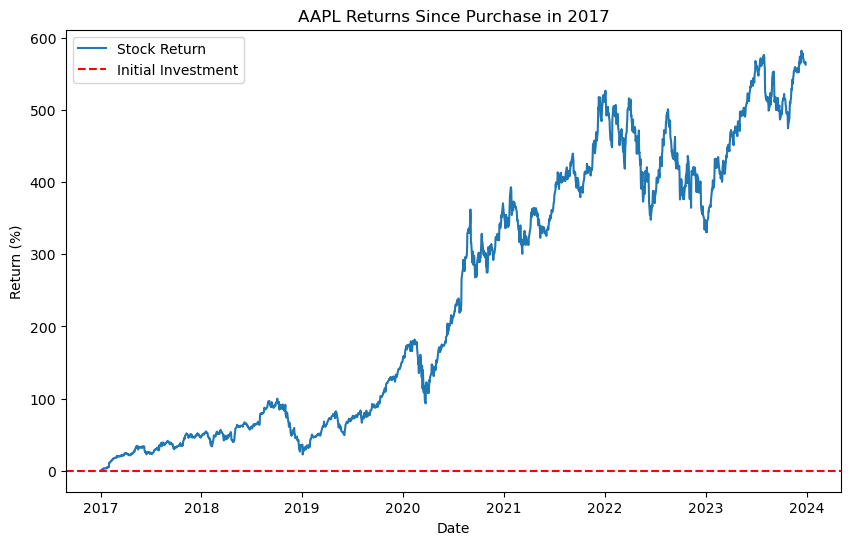

[*********************100%%**********************]  1 of 1 completed


Bought META in 2016. Total return until 2024: 246.27%
Shape ratio 0.598
Volatility 38.825%
Max Draw Down -76.736


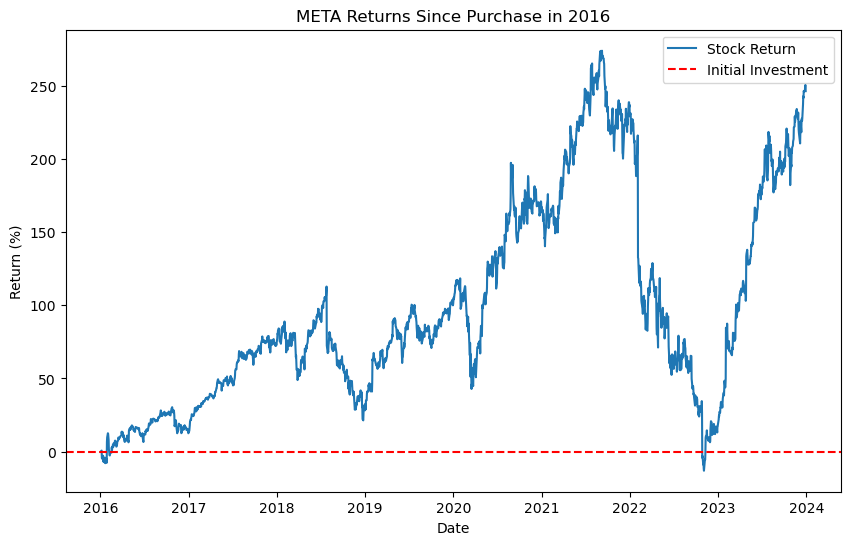

[*********************100%%**********************]  1 of 1 completed


Bought AMZN in 2018. Total return until 2024: 155.57%
Shape ratio 0.62
Volatility 35.355%
Max Draw Down -56.145


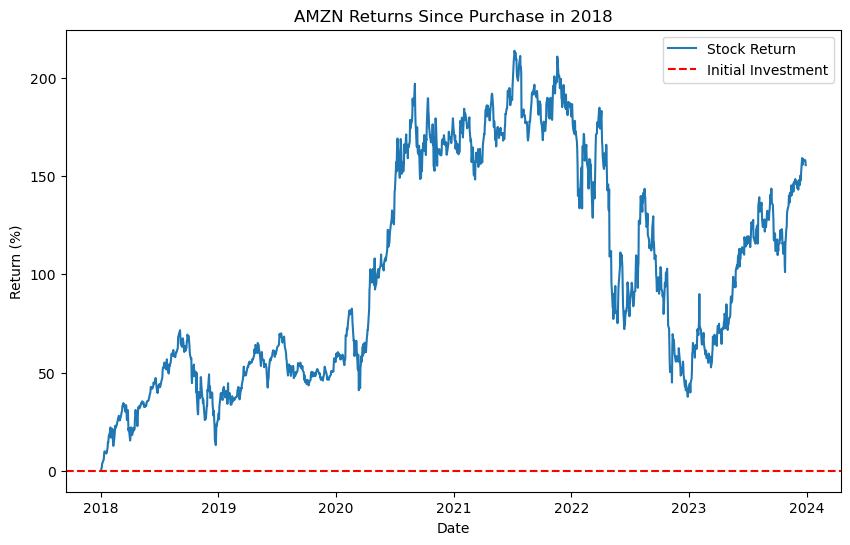

[*********************100%%**********************]  1 of 1 completed


Bought CRM in 2019. Total return until 2024: 94.13%
Shape ratio 0.537
Volatility 38.401%
Max Draw Down -58.617


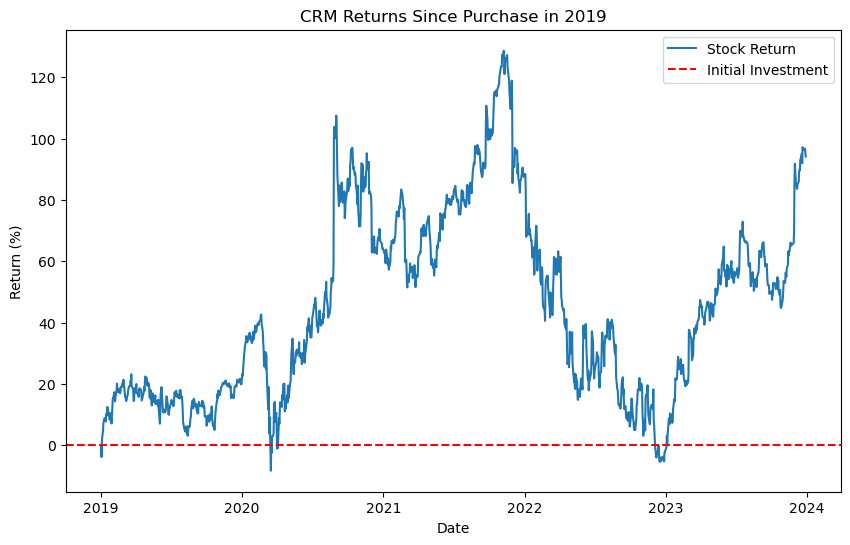

[*********************100%%**********************]  1 of 1 completed


Bought BABA in 2016. Total return until 2024: 1.07%
Shape ratio 0.213
Volatility 42.945%
Max Draw Down -80.088


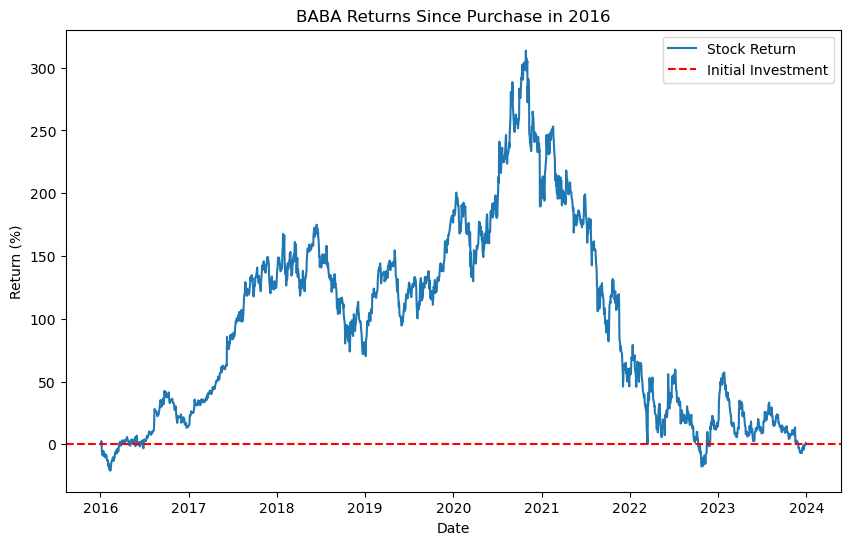

[*********************100%%**********************]  1 of 1 completed


Bought NVDA in 2018. Total return until 2024: 893.67%
Shape ratio 1.004
Volatility 51.354%
Max Draw Down -66.335


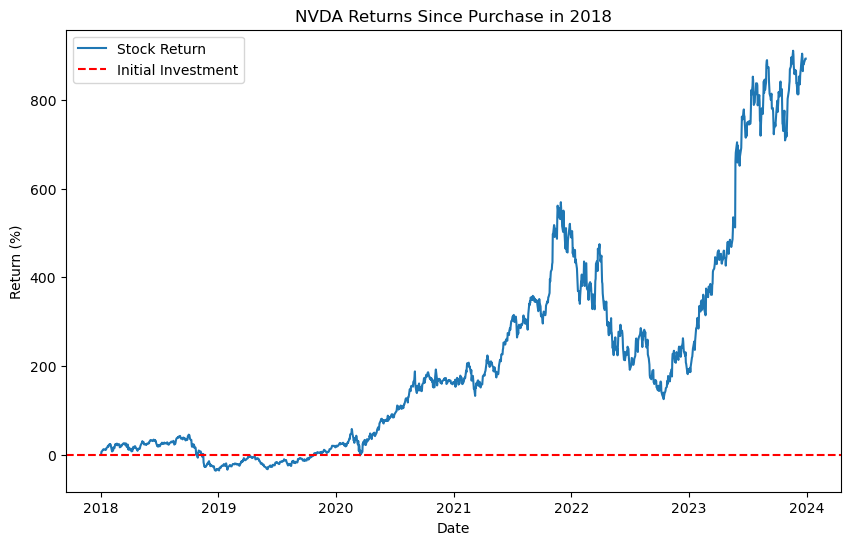

[*********************100%%**********************]  1 of 1 completed


Bought NFLX in 2017. Total return until 2024: 281.90%
Shape ratio 0.662
Volatility 44.059%
Max Draw Down -75.947


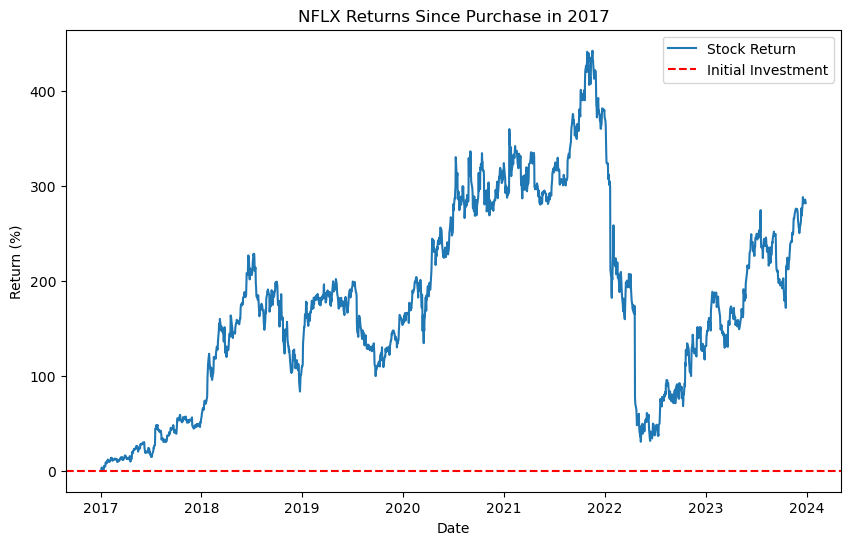

In [242]:
# Example usage for a stock ticker (e.g., AAPL)
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "AAPL" ,"EPS_AAPL")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "META" ,"EPS_META")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "AMZN" ,"EPS_AMZN")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "CRM" ,"EPS_CRM")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "BABA" ,"EPS_BABA")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "NVDA" ,"EPS_NVDA")
stock_data, return_value, buy_year = find_consecutive_growth(eps_data, "NFLX" ,"EPS_NFLX")
